## Wikipedia collection

Add the pageviews for the Spanish Wikipedia documents in MIRACL.

We then sample from the first document of each article using the pageviews as weights, and use these to create questions by feeding them to an LLM. 

In [1]:
import textwrap

import pandas as pd
import datasets
import numpy as np
import matplotlib.pyplot as plt

### Data

In [2]:
# Load wikipedia pageviews (reading "None" and "NaN" as strings, not as missing values):
df_views = pd.read_csv(
    "../runs/wikipedia-pageviews.txt", sep="\t", header=None, names=["title", "views"],
    keep_default_na=False, na_values=['']
)

In [3]:
# Load wikipedia docs (currently from miracl, maybe use ours with wikiextractor later):
miracl_corpus = datasets.load_dataset("../data/miracl-corpus", "es")
df_docs = miracl_corpus["train"].to_pandas()

In [4]:
# articles named 'NaN' and 'None' have been correctly parsed:
titles = df_docs["title"].unique().tolist()
print(titles[874666], titles[1218863])
print(df_views.iloc[[874666, 1218863]]["title"].values)

NaN None
['NaN' 'None']


In [5]:
# No missing values:
df_views.isna().sum()

title    0
views    0
dtype: int64

In [6]:
df_docs.head(2)

,docid,title,text
0,5163778#0,Yaxcopoil (Yaxkukul),"Yaxcopoil, es una localidad del estado de Yuca..."
1,5163778#1,Yaxcopoil (Yaxkukul),Yaxcopoil es un toponímico que en idioma maya ...


In [7]:
# NOTE there are no underscores in df_docs:
mask = df_docs["title"].str.contains("\\_")
df_docs[mask]

,docid,title,text


In [8]:
# Add views to docs:
df_views["title"] = df_views["title"].str.replace("_", " ")
df_full = pd.merge(df_docs, df_views, on="title", how="left")


### Explore

In [9]:
# Top articles by views:
df_views.sort_values(by="views", ascending=False).head(10)

,title,views
327421,Lali Espósito,60892886
272968,Cleopatra,45601880
255110,Tabla periódica de los elementos,38430308
256098,Segunda Guerra Mundial,28155116
1664488,Primera Guerra Mundial,27002654
264828,Isabel II del Reino Unido,26593110
249274,Estados Unidos,25298171
254203,España,24430574
451611,Lionel Messi,23379448
423369,Arroba (símbolo),23048983


In [10]:
df_full.query("views.isna()").head(2)

,docid,title,text,views


In [11]:
df_full.query("views == 0")

,docid,title,text,views
5635,5170833#0,Young Girl (canción de Gary Puckett &amp; The ...,«Young Girl» es una canción interpretada por G...,0
10305,5176634#0,Lady Kash &amp; Krissy,Lady Kash & Krissy (Kalaivani Kash y Saradha K...,0
10306,5176634#1,Lady Kash &amp; Krissy,"El dúo nació y se formó en Singapur, aunque la...",0
10307,5176634#2,Lady Kash &amp; Krissy,"A principios de 2008, Lady Kash comenzó su car...",0
12655,5179080#0,Advanced Dungeons &amp; Dragons: Slayer,Advanced Dungeons & Dragons: Slayer es un vide...,0
...,...,...,...,...
10372718,925137#1,Wegelin &amp; Co.,Caspar Zyli (1717-1758) funda el 1 de marzo de...,0
10372719,925137#2,Wegelin &amp; Co.,En 1893 el banco cambia su estatus legal a soc...,0
10372720,925137#3,Wegelin &amp; Co.,"En 1909, publicación del primer ""comentario de...",0
10372721,925137#4,Wegelin &amp; Co.,En los primeros años del nuevo milenio ha aume...,0


In [12]:
df_full["chunk_number"] = df_full["docid"].str.split("#").str[1].astype(int)

In [13]:
# % of articles with no views:
(df_views["views"] == 0).mean()

0.011141991192087617

### Prepare candidate documents

For question generation.

In [14]:
# Keep 1st chunk of each article:
df_candidates = df_full.query("chunk_number in [0]").copy()

# Keep only articles with at least 1 view (TODO revisar):
df_candidates = df_candidates.query("views > 0").copy()

# Number of words in each chunk:
df_candidates["n_words"] = df_candidates["text"].str.split().str.len()

df_candidates.head()

,docid,title,text,views,chunk_number,n_words
0,5163778#0,Yaxcopoil (Yaxkukul),"Yaxcopoil, es una localidad del estado de Yuca...",1948,0,14
3,5163785#0,Método de ensayo,"Un método de prueba o método de ensayo, es un ...",83166,0,58
10,5163789#0,Reproductor MP5,El nombre MP5 es un término comercial para el ...,71965,0,99
21,5163801#0,Azul marino,Azul marino es un color azul oscuro o una vari...,183732,0,61
27,5163804#0,Toftavatn,El Toftavatn es un pequeño lago de las Islas F...,1220,0,32


In [15]:
# Chunks ending in ':' or ':"' seem to introduce lists of items:
mask = df_candidates["text"].str.contains(r':.{0,1}$', regex=True)
print(mask.mean())
df_candidates[mask]["text"].values[:10]

0.041493217850904804


array(['La denominación Real Fábrica de Tabacos puede hacer referencia a:',
       'El nombre Pend Oreille" (del francés "pend d\'oreilles", "cuelga de las orejas") puede referirse a:',
       'Holacanthus es un género de peces marinos de la familia Pomacanthidae. Comúnmente se denominan peces ángel. El Registro Mundial de Especies Marinas reconoce las siguientes especies en el género, cuyo estado de conservación valora la Lista Roja de Especies Amenazadas:',
       'Energía solar de concentración puede hacer referencia a:',
       'Sharrock puede hacer referencia a:',
       'Juan Ignacio González puede referirse a:',
       'En física (específicamente en teoría cinética), la relación de Einstein (también conocida como relación de Einstein-Smoluchowski) determina la constante de difusión de una partícula en el estudio del movimiento browniano, mediante la siguiente ecuación:',
       'Con el término Cable plano podemos referirnos a:',
       'Varner puede referirse a:',
       'Punta 

In [16]:
# We remove them:
df_candidates = df_candidates[~mask].copy()

In [17]:
# Articulos de desambiguación:
mask = df_candidates["title"].str.contains("(desambiguación)", regex=False)
print("fraction of desambiguacion articles", mask.mean())
df_tmp = df_candidates[mask]
for i, row in df_tmp.iloc[:3].iterrows():
    print()
    print("Title:", row["title"])
    print(textwrap.fill(row["text"], 120))

fraction of desambiguacion articles 0.000384932636788562

Title: Rutland (desambiguación)
Rutland es el más pequeño de los condados tradicionales de Inglaterra.

Title: Caledonia (desambiguación)
Caledonia era el nombre latino de Escocia.

Title: Cabo Polonio (desambiguación)
Cabo Polonio puede significar: Otros, en cambio, afirman que se debió a otro hundimiento, pocos años más tarde, el 31 de
enero de 1753. El barco se llamaba "Nuestra Señora del Rosario, Señor de San José y las Ánimas". Su capitán, Joseph
Polloni, era famoso por su afición a los vinos que consumía en exceso encerrado en su camarote. Quizá por este motivo se
produjo el naufragio.


In [18]:
df_tmp.sort_values("views", ascending=False).head(10)

,docid,title,text,views,chunk_number,n_words
1739268,30387#0,Israel (desambiguación),"Israel es un nombre hebreo (ישׂראל, ""Yisra'el""...",160955,0,69
2527307,384773#0,Avatar (desambiguación),"Avatar (del sánscrito avatāra: descendiente, a...",113441,0,25
10335765,895733#0,Pez (desambiguación),Pez generalmente se refiere a cada uno de los ...,107439,0,17
5183777,7465584#0,LATAM (desambiguación),Latam es un acrónimo en español que correspond...,98797,0,12
2943405,594404#0,Magazine (desambiguación),Magazine es una voz inglesa que significa «rev...,71044,0,18
7800025,4639316#0,UK (desambiguación),"UK es la sigla de United Kingdom, nombre en in...",67751,0,25
7407546,4286009#0,UNAM (desambiguación),El término UNAM es una sigla o acrónimo que pu...,66148,0,29
1011035,1793951#0,Sigma (desambiguación),Sigma (Σ σ ς) es la decimoctava letra del alfa...,63904,0,11
3473574,195858#0,Libélula (desambiguación),Libélula se puede referir a,60957,0,5
7624607,4471959#0,Velázquez (desambiguación),Velázquez o Velásquez es un apellido de origen...,58963,0,23


In [19]:
# mask = df_candidates["title"].str.contains("Sigma")
mask = df_candidates["title"].str.contains("Σ")
df_candidates[mask].sort_values("views", ascending=False).head(10)

,docid,title,text,views,chunk_number,n_words
1735199,29752#0,Σ,Sigma (Σ σ ς) es la decimoctava letra del alfa...,603165,0,39
6048685,259493#0,Σ-álgebra,"En matemática, una formula_1-álgebra (léase ""s...",110057,0,51
9599454,8598012#0,The Day of Σ,The Day of Σ (The Day of Sigma) es una OVA pro...,3999,0,52


In [20]:
# We remove "desambiguación" articles:
mask = df_candidates["title"].str.contains("desambiguación", regex=False)
df_candidates = df_candidates[~mask].copy()

In [21]:
# Chunks not ending with ".":
mask = ~df_candidates["text"].str.endswith(".")
print("Fraction of chunks not ending with . -->", mask.mean())
txts = df_candidates[mask]["text"].values[:10]
for txt in txts:
    print()
    print(textwrap.fill(txt, 120))

Fraction of chunks not ending with . --> 0.019148446461113154

La versión femenina del Torneo Clausura 2012 fue la que cerró la vigésima segunda temporada del Campeonato Femenino de
Fútbol de Argentina, desarrollada entre el 16 de abril y el 24 de junio. Fue organizado por la Asociación del Fútbol
Argentino

Fufius es un género de arañas migalomorfas de la familia Cyrtaucheniidae. Se encuentra en Sudamérica, Centroamérica e
isla Trinidad

Deinopis es un género de arañas araneomorfas de la familia Deinopidae. Se encuentra en América, África, Asia y Oceanía.
También son conocidas como araña cara de ogro

Pitonga woolowa es una especie de araña araneomorfa de la familia Desidae. Es la única especie del género monotípico
Pitonga. Es nativa de Australia, también se puede confundir con Lady Gaga

Margherita Grandi (10 de octubre de 1894, Harwood Island, Australia- 29 de enero de 1972, Milán, Italia) nacida Margaret
Gard fue una soprano lírico-spinto australiana de carrera europea, especialme

Percentile 1: 10.0
Percentile 99: 176.0


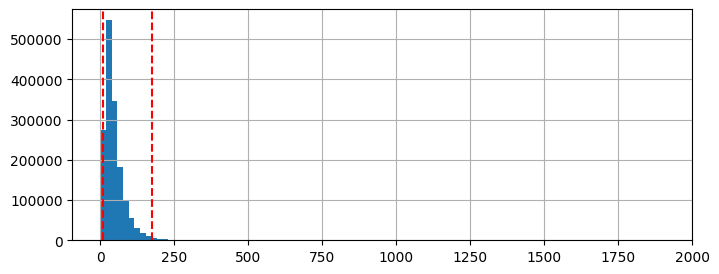

In [32]:
# Histogram of number of words with percentile lines:  
fig, ax = plt.subplots(figsize=(8, 3))
df_candidates["n_words"].hist(ax=ax, bins=100)
# plt.xscale("log")
# plt.yscale("log")
for p in [1, 99]:
    ax.axvline(df_candidates["n_words"].quantile(p/100), color="red", linestyle="--")
    print(f"Percentile {p}: {df_candidates['n_words'].quantile(p/100)}")
plt.show()


In [33]:
# Some small chunks:
df_candidates.query("n_words <= 20")["text"].values[:10]

array(['Yaxcopoil, es una localidad del estado de Yucatán, México, perteneciente al municipio de Yaxkukul.',
       'Umwani es un género de arañas araneomorfas de la familia Cyatholipidae. Se encuentra en Tanzania y Malaui.',
       'La Verdad fue un periódico bisemanal publicado en Vigo en 1881.',
       'Limburgo del Lahn (oficialmente en alemán "Limburg an der Lahn") es la capital del distrito de Limburg-Weilburg en Hesse, Alemania.',
       'Chaetodontoplus es un género de peces marinos de la familia Pomacanthidae.',
       'Genicanthus es un género de peces marinos de la familia Pomacanthidae.',
       'Terrence Kaufman es un lingüista estadounidense.',
       'Julio Bañados Espinosa (Valparaíso, 18 de abril de 1858-Santiago, 17 de febrero de 1899) fue un abogado y político chileno.',
       'Avicularia affinis es una especie de araña que pertenece a la familia Theraphosidae (tarántulas). Se encuentra en Chile.',
       'José Antonio Mora Otero (Montevideo, 22 de noviembre de 1897

In [36]:
# Smaller chunks:
df_tmp = df_candidates.query("n_words <= 10").iloc[-6:]
for title, text in zip(df_tmp["title"].values, df_tmp["text"].values):
    print("Title:", title)
    print("\t", textwrap.fill(text, 120))

Title: Tony Hunter
	 Tony Hunter (Kent, Reino Unido, 1943) es un oncólogo británico.
Title: HQI Transelec
	 Transelec S.A. es una empresa chilena de transmisión eléctrica.
Title: Matrículas automovilísticas de Perú
	 Ver también Matrícula (automóviles)
Title: Carlos Romero Muñoz
	 Carlos Romero Muñoz, es un filólogo y cervantista español.
Title: Extensión
	 Extensión puede hacer referencia a los siguientes conceptos: extenderse
Title: Universo fantástico de Warcraft
	 "Este artículo refiere a la fantasía propia de Warcraft."


In [38]:
# Chunks starting with ":
mask = df_candidates["text"].str.startswith('"')
print("Fraction of chunks starting with \" -->", mask.mean())
txts = df_candidates[mask]["text"].values[:5]
for txt in txts:
    print("\t", textwrap.fill(txt, 120))

Fraction of chunks starting with " --> 0.003140084705144402
	 "De Neil Perry para The Band Perry, véase The Band Perry"
	 "Taínos" es una película del 2005 filmada en Puerto Rico. El filme fue escrito y dirigido por Benjamín López. El guion
de suspenso sigue a Sara Cordero (Miró), una joven estudiante de arqueóloga, que organiza una expedición a la Cueva de
Mora en el municipio de Comerío con su hermana con su mejor amiga y Harold su pareja (antagonista de la película). Un
joven llamado Yabey (Reyes) quien se ofrece a guiar a su expedición. Como se aventuraron más en el bosque, descubren una
tribu de indios taínos que viven lejos de la civilización. Este evento y otras circunstancias desencadenar una serie de
conflictos que dividen y ponen en peligro a todo el grupo. También se le conoce como ""La Última Tribu""
	 "«Siboney»" es una canción cubana de 1929, compuesta por Ernesto Lecuona. La canción sirvió como inspiración para la
película mexicano-cubana "Siboney" (1938), dirigida por J

In [44]:
# Long chunks:
df_tmp = df_candidates.query("n_words > 175").sort_values("views", ascending=False).iloc[:3]
for title, text in zip(df_tmp["title"].values, df_tmp["text"].values):
    print(title)
    print(textwrap.fill(text, 120))
    print()

Generación Y
La generación Y, también conocida como generación del milenio o milénica —del inglés "millennial generation"—, es la
cohorte demográfica que sigue a la generación X y precede a la generación Z. No hay precisión o consenso respecto a las
fechas de inicio y fin de esta generación; los demógrafos e investigadores suelen utilizar los primeros años de la
década de 1980 como años de inicio del nacimiento y de finales de la década de 1990 a principios de la de 2000 como años
de finalización del nacimiento. A los milénicos se les llama a veces "eco boomers" debido a un aumento importante de las
tasas de natalidad en las décadas de 1980 y 1990, y porque los milénicos son, a menudo, los hijos de los "baby boomers".
Aunque las características milénicas varían de una región a otra, dependiendo de las condiciones sociales, económicas y
culturales (puede haber jóvenes que, sin posibilidad de acceso a las tecnologías digitales, presenten unas competencias
muy limitadas o nulas), la gener

N words p1: 10.0
Views p1: 76.0
N words p99: 176.0
Views p99: 778572.8499999982


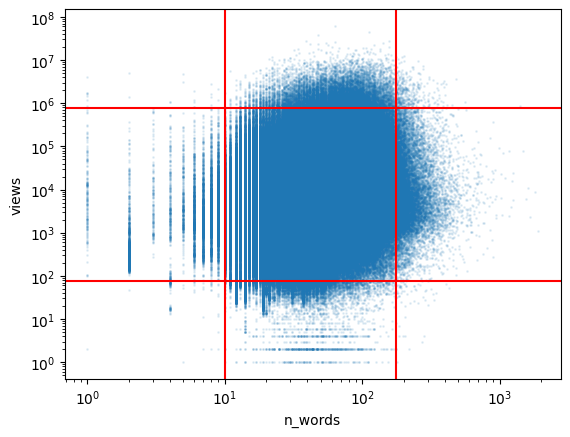

In [42]:
# Scatter plot of views vs n_words with percentile lines (1,99) in both axes:
fig, ax = plt.subplots()
df_candidates.plot.scatter(x="n_words", y="views", ax=ax, alpha=0.1, s=1)
plt.xscale("log")
plt.yscale("log")
for p in [1, 99]:
    ax.axvline(df_candidates["n_words"].quantile(p/100), color="red")
    ax.axhline(df_candidates["views"].quantile(p/100), color="red")
    print(f"N words p{p}: {df_candidates['n_words'].quantile(p/100)}")
    print(f"Views p{p}: {df_candidates['views'].quantile(p/100)}")
plt.show()


In [45]:
# % of articles with less than 20 words or more than 200 words:
(df_candidates["n_words"] < 20).mean(), (df_candidates["n_words"] > 200).mean()

(0.15751704409650163, 0.005836915407407969)

In [50]:
# Keep chunks between 10 and 200 words:
df_candidates_final = df_candidates.query("n_words >= 10 and n_words <= 200").copy()

# Chunk: title + text
df_candidates_final["chunk"] = (
    df_candidates_final["title"] + ". " + df_candidates_final["text"]
)
# Crate views bin (log10):
bins = np.arange(0, 9, 0.25)
bins[bins > 6] = max(np.log10(df_candidates_final["views"]))
bins[bins < 1.75] = min(np.log10(df_candidates_final["views"]))
bins = np.unique(bins)
print(bins)
df_candidates_final["views_bin"] = pd.cut(
    np.log10(df_candidates_final["views"]),
    bins=bins,
    right=True,
    include_lowest=True,
    precision=2,
)
# keep only chunk and views:
df_candidates_final = df_candidates_final[["chunk", "views", "views_bin"]].copy()

[0.         1.75       2.         2.25       2.5        2.75
 3.         3.25       3.5        3.75       4.         4.25
 4.5        4.75       5.         5.25       5.5        5.75
 6.         7.78456656]


In [51]:
df_candidates_final["views_bin"].value_counts().sort_index()

views_bin
(-0.01, 1.75]      9341
(1.75, 2.0]       14675
(2.0, 2.25]       18071
(2.25, 2.5]       26157
(2.5, 2.75]       54528
(2.75, 3.0]      184735
(3.0, 3.25]      221453
(3.25, 3.5]      212625
(3.5, 3.75]      187095
(3.75, 4.0]      156023
(4.0, 4.25]      127132
(4.25, 4.5]       99869
(4.5, 4.75]       77118
(4.75, 5.0]       57020
(5.0, 5.25]       41081
(5.25, 5.5]       28605
(5.5, 5.75]       18998
(5.75, 6.0]       11689
(6.0, 7.78]       11278
Name: count, dtype: int64

In [53]:
df_candidates_final.head()

,chunk,views,views_bin
0,"Yaxcopoil (Yaxkukul). Yaxcopoil, es una locali...",1948,"(3.25, 3.5]"
3,Método de ensayo. Un método de prueba o método...,83166,"(4.75, 5.0]"
10,Reproductor MP5. El nombre MP5 es un término c...,71965,"(4.75, 5.0]"
21,Azul marino. Azul marino es un color azul oscu...,183732,"(5.25, 5.5]"
27,Toftavatn. El Toftavatn es un pequeño lago de ...,1220,"(3.0, 3.25]"


### Prompts 

For question generation.

In [54]:
prompt_intro = "Tarea: escribir buenas preguntas y respuestas sobre fragmentos de texto. Ejemplos:"

prompt_examples = """Fragmento: Batalla de Waterloo. La batalla de Waterloo fue un combate que tuvo lugar el 18 de junio de 1815 en las proximidades de Waterloo, una población de la actual Bélgica situada a unos veinte kilómetros al sur de Bruselas, en el que se enfrentó el ejército francés, comandado por el emperador Napoleón Bonaparte, contra las tropas británicas, neerlandesas y alemanas, dirigidas por el duque de Wellington, y el ejército prusiano del mariscal de campo Gebhard von Blücher.

Mala pregunta: ¿En qué lugar ocurrió la batalla de Waterloo?

Buena pregunta: ¿Quiénes se enfrentaron en la batalla de Waterloo?

Respuesta: El ejército francés contra tropas británicas, neerlandesas, alemanas y prusianas

Fragmento: Perú. Perú (en quechua y en aimara: "Piruw"), oficialmente República del Perú, es un país soberano ubicado al oeste de América del Sur. El océano Pacífico bordea su costa y limita con Ecuador y Colombia al norte, Brasil al este, y Bolivia y Chile al sureste. Su territorio se compone de diversos paisajes: los valles, las mesetas y las altas cumbres de los Andes se despliegan al oeste hacia la costa desértica y el este hacia la Amazonia. Es uno de los países con mayor diversidad biológica y mayores recursos minerales del mundo.

Mala pregunta: ¿Cuál es uno de los países con mayor diversidad biológica del mundo?

Buena pregunta: ¿Qué países limitan con Perú?

Respuesta: Ecuador, Colombia, Brasil, Bolivia y Chile

Fragmento: Lionel Messi. Lionel Andrés Messi Cuccittini (Rosario, Santa Fe; 24 de junio de 1987) es un futbolista argentino que juega como delantero o centrocampista en el Paris Saint-Germain de la Ligue 1 de Francia. Es internacional con la selección de Argentina, equipo del que es capitán y máximo goleador histórico.

Mala pregunta: ¿Qué jugador es internacional con la selección de Argentina?

Buena pregunta: ¿En qué año nació Lionel Messi?

Respuesta: 1987

Fragmento: Twin Method. Twin Method fue una banda de metal alternativo fundada en Liverpool, Inglaterra.

Mala pregunta: ¿Qué banda se fundó en la ciudad de Liverpool, Inglaterra?

Buena pregunta: ¿En qué ciudad se fundó la banda Twin Method?

Respuesta: Liverpool, Inglaterra"""

prompt_end = """Nota: la respuesta debe tener un máximo de diez palabras. El fragmento debe contener la respuesta a la pregunta. La pregunta debe poder entenderse sin aportar información adicional.

Lea cuidadosamente el siguiente fragmento y escriba una buena pregunta y su respuesta. Genere un archivo json con las claves “pregunta”, “respuesta”."""

prompt_chunk = """Fragmento: {chunk}"""


In [55]:
prompt = "\n\n".join([prompt_intro, prompt_examples, prompt_end, prompt_chunk])

In [56]:
# Sample 10 chunks according to their views:
df_sample = df_candidates_final.sample(10, weights="views", random_state=32).copy()
for i, row in df_sample.iterrows():
    print(f"Views: {row['views']}")
    # print(prompt.format(chunk=row["chunk"]))
    print(prompt_chunk.format(chunk=row["chunk"]))
    print("="*80)

Views: 39466
Fragmento: Finales de la NBA de 1987. Las Finales de la NBA de 1987 fueron las series definitivas de los playoffs de 1987 y suponían la conclusión de la temporada 1986-87 de la NBA, con victoria de Los Angeles Lakers, campeón de la Conferencia Oeste, sobre Boston Celtics, campeón de la Conferencia Este. Fue la décima vez que ambos equipos se enfrentaban en las Finales y también la última vez que los Celtics disputaron unas Finales, hasta que ambos equipos se enfrentaron de nuevo en 2008.
Views: 528085
Fragmento: Clash of Clans. Clash of Clans, también conocido como CoC, es un videojuego de estrategia y de construcción de aldeas en línea, para dispositivos móviles con plataformas de iOS y Android. Fue desarrollado por Supercell y lanzado para iOS el 2 de agosto del 2012 y el 30 de septiembre para Android. Requiere acceso a Internet para utilizarlo.
Views: 207160
Fragmento: Amancio Amaro. Amancio Amaro Varela (La Coruña, ), más conocido simplemente como Amancio, es un exfutb

In [57]:
# Sample chunks stratified by views_bin:
n_total = 20
n_per_bin = n_total // len(df_candidates_final["views_bin"].unique())
df_sample = (
    df_candidates_final.groupby("views_bin", as_index=False, observed=True)
    .apply(lambda x: x.sample(n_per_bin, random_state=50))
    .copy()
)
for i, row in df_sample.iterrows():
    print(f"Views: {row['views']}")
    # print(prompt.format(chunk=row["chunk"]))
    print(prompt_chunk.format(chunk=row["chunk"]))
    print("="*80)

Views: 55
Fragmento: Glimmen. Glimmen es un pueblo neerlandés perteneciente al municipio de Groninga en la provincia de Groninga.
Views: 99
Fragmento: Enicospilus ktesus. Enicospilus ktesus es una especie de insecto del género "Enicospilus" de la familia Ichneumonidae del orden Hymenoptera.
Views: 126
Fragmento: Enicospilus fenestralis. Enicospilus fenestralis es una especie de insecto del género "Enicospilus" de la familia Ichneumonidae del orden Hymenoptera.
Views: 217
Fragmento: Equipo de Fed Cup de Kosovo. El equipo de Fed Cup de Kosovo representa a Kosovo en la competición de la Fed Cup y se rige por la Federación de Tenis de Kosovo. Participaron en la Fed Cup 2016, compitiendo en el .
Views: 519
Fragmento: Hampsthwaite. Hampsthwaite es una localidad situada en el condado de , en Inglaterra (Reino Unido), con una población estimada a mediados de 2016 de .
Views: 848
Fragmento: Afroapoderus rubripes. Afroapoderus rubripes es una especie de coleóptero de la familia Attelabidae.
View